In [1]:
import os
import sys

sys.path.append(os.path.realpath('..'))

import pandas as pd
pd.options.display.max_colwidth = 100

import numpy as np
import seaborn as sns
import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

def keth(x, pos):
    'The two args are the value and tick position'
    return '%1.fK' % (x * 1e-3)
keth_formatter = FuncFormatter(keth)

In [2]:
df = pd.read_gbq("""
select concat(CAST(EXTRACT(MONTH from block_timestamp) as string), "-", CAST(EXTRACT(YEAR from block_timestamp) as string)) as monthyear, 
CASE
    WHEN num_token_transfers > 0 THEN "ERC20"
    ELSE "OTHER"
END as is_erc20,
CASE
    WHEN ((num_token_transfers > 1) and (unique_token > 1)) THEN "SWAP"
    ELSE "OTHER"
END as is_swap,
sum(pf.priority_fees) as priority_fees, sum(df.direct_payment) as direct_payment
 from
(SELECT 
  *, 
  receipt_gas_used*cast(max_priority_fee_per_gas as numeric)/pow(10, 18) as priority_fees  
  FROM `bigquery-public-data.crypto_ethereum.transactions` WHERE DATE(block_timestamp) > "2022-10-01") as pf
LEFT JOIN
(SELECT transaction_hash as tx_hash, value/pow(10, 18) as direct_payment
from
  (  SELECT number, timestamp, miner 
FROM `bigquery-public-data.crypto_ethereum.blocks` 
WHERE DATE(timestamp) > "2022-10-01") as b
inner join 
(
  SELECT block_number, value, transaction_hash, to_address FROM `bigquery-public-data.crypto_ethereum.traces` 
WHERE DATE(block_timestamp) > "2022-10-01"
and value > 0
and status = 1
) as tr
on b.number = tr.block_number and tr.to_address = b.miner) as df
on pf.hash = df.tx_hash
LEFT JOIN
(SELECT 
  transaction_hash, count(1) as num_token_transfers, count(distinct(token_address)) as unique_token
  FROM `bigquery-public-data.crypto_ethereum.token_transfers` WHERE DATE(block_timestamp) > "2022-10-01"
  GROUP BY 1) as tt
  ON tt.transaction_hash = pf.hash
GROUP BY 1, 2, 3
""")

/Users/ankitchiplunkar/projects/crypto_charts/venv/lib/python3.10/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
df

,monthyear,is_erc20,is_swap,priority_fees,direct_payment
0,1-2023,OTHER,OTHER,3530.242246,441.815272
1,12-2022,ERC20,SWAP,4906.532709,5738.264067
2,1-2023,ERC20,SWAP,6927.623454,7309.935197
3,2-2023,ERC20,OTHER,2492.957837,125.627189
4,11-2022,ERC20,SWAP,8831.658152,18426.435955
5,10-2022,ERC20,OTHER,3182.467646,66.338198
6,11-2022,OTHER,OTHER,3383.340502,155.409302
7,2-2023,OTHER,OTHER,2274.082206,825.133514
8,12-2022,OTHER,OTHER,2676.753549,310.471656
9,2-2023,ERC20,SWAP,8543.690708,5597.586042


In [4]:
total = df.sum()
is_erc20 = df[df['is_erc20'] == 'ERC20'].sum()
is_swap = df[df['is_swap'] == 'SWAP'].sum()
d = {
        'type': ['All Transactions', 'ERC20 transfers', 'Swaps'], 
        'priority_fees': [total.priority_fees, is_erc20.priority_fees, is_swap.priority_fees],
        'direct_payment': [total.direct_payment, is_erc20.direct_payment, is_swap.direct_payment]
}
df_final = pd.DataFrame(data=d)

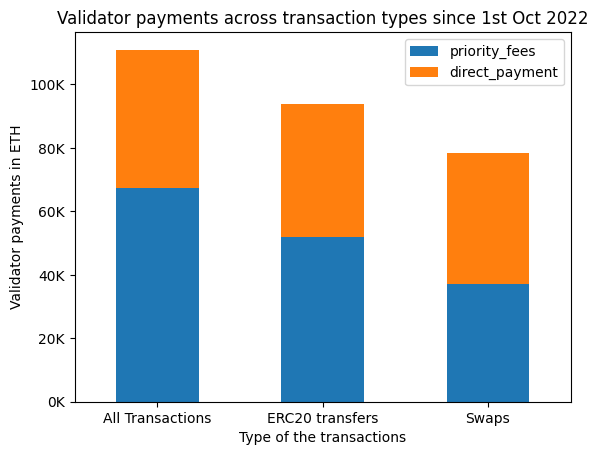

In [5]:
ax = df_final.set_index('type').plot(kind='bar', stacked=True)
ax.set_title('Validator payments across transaction types since 1st Oct 2022')
ax.set_xlabel('Type of the transactions')
ax.set_ylabel('Validator payments in ETH')
ax.yaxis.set_major_formatter(keth_formatter)
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

In [6]:
to_plot = df_final.set_index('type').unstack().reset_index().rename(columns={'level_0': 'Fee Type', 0: 'value'})
fig = px.funnel(
    to_plot, 
    x='value', 
    y='type', 
    color='Fee Type', 
    title="Validator rewards (in ETH) by transaction types",
    labels={
                         "value": "Validator payment in ETH",
                         "type": "Type of transactions",
                     },
)
fig.update_traces(texttemplate="%{value:,.2s}")
fig.show()


In [22]:
total_value = total.priority_fees + total.direct_payment
swap_value = is_swap.priority_fees + is_swap.direct_payment
others_value = total_value - swap_value
df2 = pd.DataFrame({'type': ['Transactions with a swap', 'Others'], 'value': [swap_value, others_value]})

Text(0, 0.5, '')

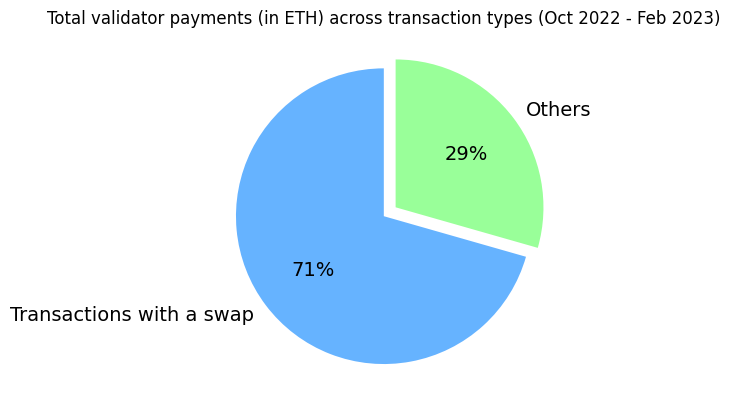

In [23]:
colors = ['#66b3ff', '#99ff99']
explode = (0, 0.1)

ax = df2.plot(kind='pie', y='value', 
              autopct='%1.0f%%', startangle=90, 
              shadow=False, labels=df2['type'], 
              legend = False, fontsize=14,
              colors=colors, explode=explode,
              )
ax.set_title('Total validator payments (in ETH) across transaction types (Oct 2022 - Feb 2023)')
ax.set_ylabel('')

In [9]:
df2


,type,value
0,Swaps,78307.876362
1,Others,32647.617953


In [10]:
df2.sum()

type       SwapsOthers
value    110955.494315
dtype: object